<img src="../squeemos_blk.png" width=200 height=200 />

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # makes the notebook fill the whole window

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns; sns.set()
import csv

from PIL import Image, ImageDraw
import os
import shutil

from mpl_toolkits.basemap import Basemap

from BetterMap import CreateMapBackground
from MakeGif import MakeGif

import math

import functools
import operator

import datetime

#there is currently a bug in panda's scatter_matrix that produces a warning that has no affect on what I'm doin :)
import warnings
warnings.filterwarnings("ignore")

## Clustering functions

In [13]:
# Return kmeans cluster centers of the given dataframe
def cluster_df(df):
    if df.shape[0] > 0:
        num_clusters = 5
        if df.shape[0] < num_clusters:
            num_clusters = df.shape[0]
        kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=10, algorithm='full')
        kmeans.fit(df[['Lat', 'Long']])
        df['cluster_label'] = kmeans.fit_predict(df[['Lat', 'Long']])
        centers = kmeans.cluster_centers_
        return centers
    result = np.empty((2,1))
    result[:] = np.NaN
    return result

#These 3 functions finds clustered centers of specific parts of the storm
def create_inner_df(df):
    centers = []
    df_inner_temp = df.copy()
    df_inner_temp = df_inner_temp[df_inner_temp['distance'] <= 100]
    end = df_inner_temp['cluster'].max()
    if math.isnan(end):
        end = 0
    for current_chunk in range(1,int(end)):
        df_inner = df.copy()
        df_inner = df_inner[(df_inner['distance'] <= 100) & (df_inner['cluster'] == current_chunk)]
        centers.append(cluster_df(df_inner))
    
    #flatten the list
    centers = functools.reduce(operator.iconcat, centers, [])
    #drop nan
    centers = [x for x in centers if str(x) != 'nan']
    return centers

def create_rainband_df(df):
    centers = []
    df_rainband_temp = df.copy()
    df_rainband_temp = df_rainband_temp[(df_rainband_temp['distance'] >= 200) & (df_rainband_temp['distance'] <= 400)]
    end = df_rainband_temp['cluster'].max()
    if math.isnan(end):
        end = 0
    for current_chunk in range(1,int(end)):
        df_rainband = df.copy()
        df_rainband = df_rainband[(df_rainband['distance'] >= 200) & (df_rainband['distance'] <= 400)]
        centers.append(cluster_df(df_rainband))
    
    #flatten the list
    centers = functools.reduce(operator.iconcat, centers, [])
    #drop nan
    centers = [x for x in centers if str(x) != 'nan']
    return centers

def create_outer_df(df):
    centers = []
    df_outer_temp = df.copy()
    df_outer_temp = df_outer_temp[(df_outer_temp['distance'] >= 400) & (df_outer_temp['distance'] <= 600)]
    end = df_outer_temp['cluster'].max()
    if math.isnan(end):
        end = 0
    for current_chunk in range(1,int(end)):
        df_outer = df.copy()
        df_outer = df_outer[(df_outer['distance'] >= 400) & (df_outer['distance'] <= 600)]
        centers.append(cluster_df(df_outer))
    
    #flatten the list
    centers = functools.reduce(operator.iconcat, centers, [])
    #drop nan
    centers = [x for x in centers if str(x) != 'nan']
    return centers

## Data loading and verification

In [3]:
#load in the data
df = pd.read_csv('./Irma Storm centered/ATL_17_11_Irma_WWLLN_Locations.txt',header=None,names=["Year","Month","Day","Hour","Min","Sec","Lat","Long","Dist_East_West","Dist_North_South"],low_memory=False, delim_whitespace=True)
df.dropna(axis=0,how='any',subset=['Lat','Long'],inplace=True)

df_center = pd.read_csv('./Irma Storm centered/ATL_17_11_Irma_Reduced_Trackfile.txt',header=None,names=["Year","Month","Day","Hour","Lat","Long","Min_Pressure","Max_Winds","Unused"],low_memory=False,sep='\t')
df_center.dropna(axis=0,how='any',subset=['Lat','Long'],inplace=True)

In [4]:
display(df.info())
display(df_center.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226789 entries, 0 to 226788
Data columns (total 10 columns):
Year                226789 non-null int64
Month               226789 non-null int64
Day                 226789 non-null int64
Hour                226789 non-null int64
Min                 226789 non-null int64
Sec                 226789 non-null float64
Lat                 226789 non-null float64
Long                226789 non-null float64
Dist_East_West      226789 non-null float64
Dist_North_South    226789 non-null float64
dtypes: float64(5), int64(5)
memory usage: 19.0 MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 0 to 60
Data columns (total 9 columns):
Year            61 non-null int64
Month           61 non-null int64
Day             61 non-null int64
Hour            61 non-null int64
Lat             61 non-null float64
Long            61 non-null float64
Min_Pressure    61 non-null int64
Max_Winds       61 non-null int64
Unused          61 non-null int64
dtypes: float64(2), int64(7)
memory usage: 4.8 KB


None

In [5]:
#make a dataframe that denotes clusters based on a time interval - a new cluster every x amount of minutes
minutes_between = 30

def add_clusters_to_df(df, minutes_between):
    cluster = 0
    df_time = pd.DataFrame()
    df_time['cluster'] = 0
    for x in range(len(df['Month'].unique())):
        month = df['Month'].unique()[x]
        for y in range(len(df[df['Month'] == df['Month'].unique()[x]]['Day'].unique())):
            day = df[df['Month'] == df['Month'].unique()[x]]['Day'].unique()[y]
            for z in range(len(df[df['Day'] == df[df['Month'] == df['Month'].unique()[x]]['Day'].unique()[y]]['Hour'].unique())):
                hour = df[df['Day'] == df[df['Month'] == df['Month'].unique()[x]]['Day'].unique()[y]]['Hour'].unique()[z]
                for w in range(0,60,minutes_between):
                    minute = w
                    temp = df[(df['Month'] == month) & (df['Day'] == day) & (df['Hour'] == hour) & (df['Min'] >= minute) & (df['Min'] <= minute + minutes_between)]
                    temp['cluster'] = cluster
                    df_time = df_time.append(temp, ignore_index=True)
                    cluster+=1
    return df_time
df_time = add_clusters_to_df(df, minutes_between)
df_time['distance'] = np.sqrt((df_time['Dist_East_West'] * df_time['Dist_East_West']) + 
                                (df_time['Dist_North_South'] * df_time['Dist_North_South']))
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230720 entries, 0 to 230719
Data columns (total 12 columns):
Day                 230720 non-null float64
Dist_East_West      230720 non-null float64
Dist_North_South    230720 non-null float64
Hour                230720 non-null float64
Lat                 230720 non-null float64
Long                230720 non-null float64
Min                 230720 non-null float64
Month               230720 non-null float64
Sec                 230720 non-null float64
Year                230720 non-null float64
cluster             230720 non-null int64
distance            230720 non-null float64
dtypes: float64(11), int64(1)
memory usage: 21.1 MB


## Proof of concept/test with specific time

In [6]:
#apply date restriction
year, month, day, hour, minute = 2017, 8, 27, 18, 30

temp = df_time[(df_time['Year'] == year) &
                   (df_time['Month'] == month) &
                   (df_time['Day'] == day) &
                   (df_time['Hour'] == hour) &
                   (df_time['Min'] == minute)]
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 440 to 457
Data columns (total 12 columns):
Day                 18 non-null float64
Dist_East_West      18 non-null float64
Dist_North_South    18 non-null float64
Hour                18 non-null float64
Lat                 18 non-null float64
Long                18 non-null float64
Min                 18 non-null float64
Month               18 non-null float64
Sec                 18 non-null float64
Year                18 non-null float64
cluster             18 non-null int64
distance            18 non-null float64
dtypes: float64(11), int64(1)
memory usage: 1.8 KB


In [7]:
inner_clusters = create_inner_df(temp)
rainband_clusters = create_rainband_df(temp)
outer_clusters = create_outer_df(temp)

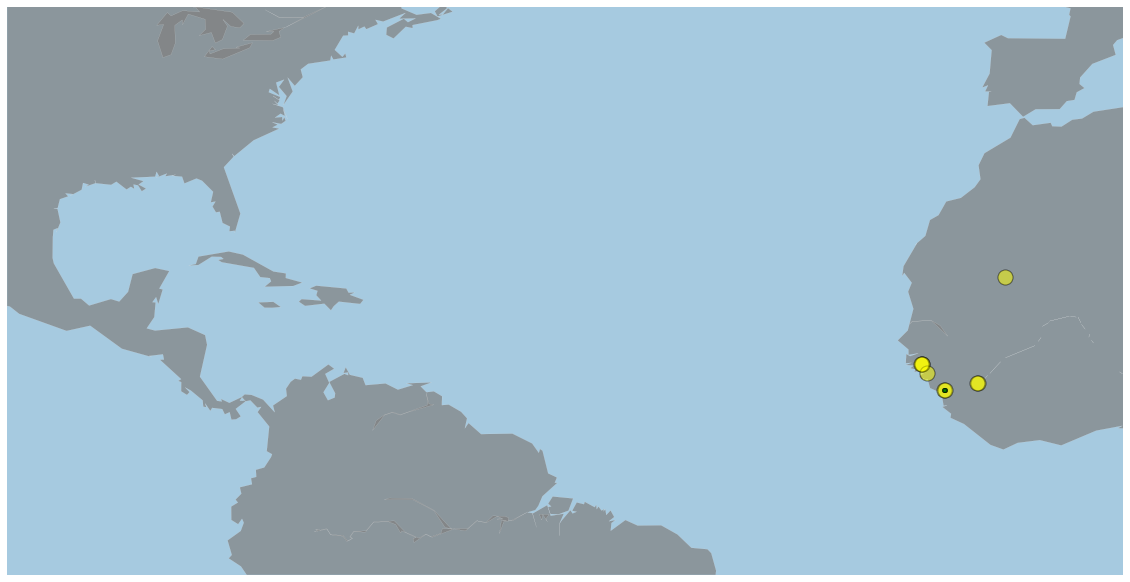

In [8]:
inner_centers = pd.DataFrame(data=inner_clusters, columns=["Lat", "Long"])
rainband_centers = pd.DataFrame(data=rainband_clusters, columns=["Lat", "Long"])
outer_centers = pd.DataFrame(data=outer_clusters, columns=["Lat", "Long"])

ln = pd.read_csv('./Irma Storm centered/ATL_17_11_Irma_WWLLN_Locations.txt',header=None,names=["Year","Month","Day","Hour","Min","Sec","Lat","Long","Dist_East_West","Dist_North_South"],low_memory=False,sep=' ')
minLong_, minLat_, maxLong_, maxLat_ = ln['Long'].min(), ln['Lat'].min(), ln['Long'].max(), ln['Lat'].max()
buffer = 10

plt.figure(figsize=(20,20))
m = Basemap(llcrnrlon=minLong_-buffer, llcrnrlat=minLat_-buffer,urcrnrlon=maxLong_+buffer,urcrnrlat=maxLat_+buffer,lon_0=0,lat_0=0)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.7, lake_color='grey')
m.drawcoastlines(linewidth=0.1, color="white")

# Plot the lightning data
m.plot(temp['Long'], temp['Lat'], linestyle='none', marker="o", markersize=15, alpha=0.3, c="yellow", markeredgecolor="black", markeredgewidth=1)
m.plot(inner_centers['Long'], inner_centers['Lat'], linestyle='none', marker=".", markersize=8, alpha=0.3, c="red", markeredgecolor="black", markeredgewidth=1)
m.plot(rainband_centers['Long'], rainband_centers['Lat'], linestyle='none', marker=".", markersize=8, alpha=0.3, c="green", markeredgecolor="black", markeredgewidth=1)
m.plot(outer_centers['Long'], outer_centers['Lat'], linestyle='none', marker=".", markersize=8, alpha=0.3, c="blue", markeredgecolor="black", markeredgewidth=1)

plt.show()

## Clustering to create a gif

In [9]:
ln = pd.read_csv('./Irma Storm centered/ATL_17_11_Irma_WWLLN_Locations.txt',header=None,names=["Year","Month","Day","Hour","Min","Sec","Lat","Long","Dist_East_West","Dist_North_South"],low_memory=False,sep=' ')
minLong_, minLat_, maxLong_, maxLat_ = ln['Long'].min(), ln['Lat'].min(), ln['Long'].max(), ln['Lat'].max()
buffer = 10

df_time = add_clusters_to_df(df, minutes_between)
df_time['distance'] = np.sqrt((df_time['Dist_East_West'] * df_time['Dist_East_West']) + 
                                (df_time['Dist_North_South'] * df_time['Dist_North_South']))
display(df_time.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230720 entries, 0 to 230719
Data columns (total 12 columns):
Day                 230720 non-null float64
Dist_East_West      230720 non-null float64
Dist_North_South    230720 non-null float64
Hour                230720 non-null float64
Lat                 230720 non-null float64
Long                230720 non-null float64
Min                 230720 non-null float64
Month               230720 non-null float64
Sec                 230720 non-null float64
Year                230720 non-null float64
cluster             230720 non-null int64
distance            230720 non-null float64
dtypes: float64(11), int64(1)
memory usage: 21.1 MB


None

In [ ]:
%%time

year = 2017
edges = (minLong_,maxLong_,minLat_,maxLat_)
di = './data/kmeans/final_gif/'

for x in range(len(df['Month'].unique())):
        month = df['Month'].unique()[x]
        for y in range(len(df[df['Month'] == df['Month'].unique()[x]]['Day'].unique())):
            day = df[df['Month'] == df['Month'].unique()[x]]['Day'].unique()[y]
            for z in range(len(df[df['Day'] == df[df['Month'] == df['Month'].unique()[x]]['Day'].unique()[y]]['Hour'].unique())):
                hour = df[df['Day'] == df[df['Month'] == df['Month'].unique()[x]]['Day'].unique()[y]]['Hour'].unique()[z]
                for w in range(0,60,minutes_between):
                    minute = w
                    temp = df_time[(df_time['Year'] == year) &
                                       (df_time['Month'] == month) &
                                       (df_time['Day'] == day) &
                                       (df_time['Hour'] == hour) &
                                       (df_time['Min'] == minute)]
                    if(temp.shape[0] > 0):
                        inner_clusters = create_inner_df(temp)
                        inner_clusters = [x for x in inner_clusters if str(x[0]) != 'nan']
                        rainband_clusters = create_rainband_df(temp)
                        rainband_clusters = [x for x in rainband_clusters if str(x[0]) != 'nan']
                        outer_clusters = create_outer_df(temp)
                        outer_clusters = [x for x in outer_clusters if str(x[0]) != 'nan']
                       
                        inner_centers = pd.DataFrame(data=inner_clusters, columns=["Lat", "Long"])
                        rainband_centers = pd.DataFrame(data=rainband_clusters, columns=["Lat", "Long"])
                        outer_centers = pd.DataFrame(data=outer_clusters, columns=["Lat", "Long"])
                        
                        fig = plt.figure(figsize=(30,15))
                        m = CreateMapBackground(edges,buffer)

                        # Plot the lightning data
                        m.plot(temp['Long'], temp['Lat'], linestyle='none', marker="o", markersize=15, alpha=0.3, c="yellow", markeredgecolor="black", markeredgewidth=1)
                        m.plot(inner_centers['Long'], inner_centers['Lat'], linestyle='none', marker=".", markersize=8, alpha=0.3, c="red", markeredgecolor="black", markeredgewidth=1)
                        m.plot(rainband_centers['Long'], rainband_centers['Lat'], linestyle='none', marker=".", markersize=8, alpha=0.3, c="green", markeredgecolor="black", markeredgewidth=1)
                        m.plot(outer_centers['Long'], outer_centers['Lat'], linestyle='none', marker=".", markersize=8, alpha=0.3, c="blue", markeredgecolor="black", markeredgewidth=1)
                        
                        #Save and close the figure
                        plt.savefig('{}{}_{}_{}_{}_{}'.format(di,year,month,day,hour,minute),bbox_inches='tight')
                        plt.close(fig)

In [11]:
MakeGif('./data/kmeans/final_gif', './data/kmeans/final_gif', 'test', 100, 'png')

In [12]:
#DEPRECATED
'''#elbow graph for visual estimation of ideal cluster count
clusters = range(1,16)

kmeans = [KMeans(n_clusters=i) for i in clusters]

y = df[['Lat']]
x = df[['Long']]

score = [kmeans[i].fit(y).score(y) for i in range(len(kmeans))]

plt.plot(clusters, score)

plt.show()'''

'''#kmeans using the set cluster count
kmeans = KMeans(n_clusters=4, init='k-means++')
cluster_df = coord_df
kmeans.fit(cluster_df)
cluster_df['cluster'] = kmeans.fit_predict(cluster_df)
inertia = kmeans.inertia_
labels = kmeans.predict(cluster_df[cluster_df.columns[:2]])
centers = kmeans.cluster_centers_

cluster_df.plot.scatter(x='Lat',y='Long', c=labels, s=50, cmap='spring', figsize=(20,20))
plt.scatter(centers[:, 0], centers[:, 1], c='black', s= 200, alpha=.5)

plt.show()'''

'''for n_clusters in range(1,16):
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++')
        kmeans.fit(cluster_df)
        inertia = kmeans.inertia_
        print("Cluster count: ", n_clusters, "\tInertia: ", inertia)
        '''

'for n_clusters in range(1,16):\n        kmeans = KMeans(n_clusters=n_clusters, init=\'k-means++\')\n        kmeans.fit(cluster_df)\n        inertia = kmeans.inertia_\n        print("Cluster count: ", n_clusters, "\tInertia: ", inertia)\n        '